In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from openai import OpenAI
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

This notebook conductes a comparaison between different embeddings in order to choose which one is the most suited to SysMLV2.

In [6]:
def generate_embeddings(tokenizer, model, code_snippets):
    '''
    Function to generate embeddings for code snippets using a given model and tokenizer from Hugging Face
    :param tokenizer: tokenizer from Hugging Face
    :param model: model from Hugging Face
    :param code_snippets: list of code snippets
    :return: list of embeddings
    '''
    embeddings_list = []
    for snippet in code_snippets:
        inputs = tokenizer(snippet, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
        with torch.no_grad():
            outputs = model(**inputs)
    
        token_embeddings = outputs.last_hidden_state
    
        code_embedding = torch.mean(token_embeddings, dim=1)
        embeddings_list.append(code_embedding)
        
    return embeddings_list

def generate_embeddings_openai(model, code_snippets):
    '''
    Function to generate embeddings for code snippets using OpenAI API
    :param model: model from OpenAI
    :param code_snippets: list of code snippets
    :return: list of embeddings
    '''
    client = OpenAI()
    embeddings_list = []
    for snippet in code_snippets:
        embeddings_list.append(client.embeddings.create(model=model, input=snippet).data[0].embedding)
    return embeddings_list

In [9]:
def compute_similarity_matrix(embeddings):
    """Compute pairwise cosine similarity for a list of embeddings."""
    embeddings = np.vstack(embeddings)
    return cosine_similarity(embeddings)

def plot_heatmap(matrix, labels, title):
    """Plot a heatmap from a similarity matrix."""
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#e6cebc", "#834d31"])  # White to #834d31
    
    plt.figure(figsize=(8, 6), facecolor="#f4f4f4")  # Set background color
    ax = sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap=custom_cmap, fmt=".2f")
    ax.set_facecolor("#f4f4f4")  # Set axes background color
    plt.title(title)
    plt.show()



### Exemple of snippets used in the comparaison

In [1]:
snippet_a = """calc heat_room {
    in temperature : TemperatureValue;
    in time : TimeValue;
    in initial_Temperature : TemperatureValue;
    in heating_factor;
    return out_temp : TemperatureValue = temperature + time * heating_factor;
}
 """
   
snippet_b = """calc cold_room {
    in temperature : TemperatureValue;
    in time : TimeValue;
    in initial_Temperature : TemperatureValue;
    in heating_factor;
    return out_temp : TemperatureValue = temperature - time * heating_factor;
}"""
   
snippet_c = """part room 
{
part air;
part cooling_system;
part heating_system;
}"""

snipets = [snippet_a, snippet_b, snippet_c]

Tokenizers are loaded from huggingface.

In [7]:
tokenizer_codeBert = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codeBert = AutoModel.from_pretrained("microsoft/codebert-base")

tokenizer_graphCodeBert = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
model_graphCodeBert = AutoModel.from_pretrained("microsoft/graphcodebert-base")

Some weights of RobertaModel were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


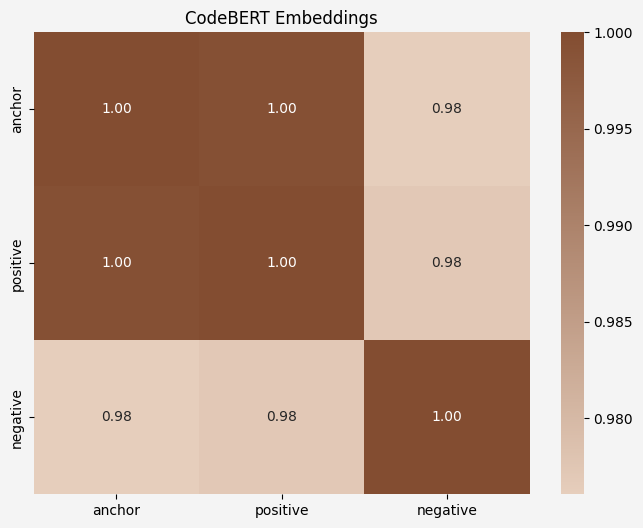

In [10]:
plot_heatmap(compute_similarity_matrix(generate_embeddings(tokenizer_codeBert, model_codeBert, snipets)), ["anchor", "positive", "negative"], "CodeBERT Embeddings")

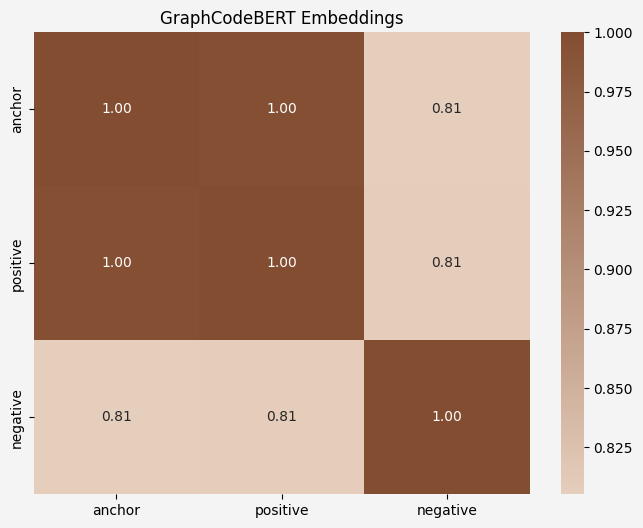

In [11]:
plot_heatmap(compute_similarity_matrix(generate_embeddings(tokenizer_graphCodeBert, model_graphCodeBert, snipets)), ["anchor", "positive", "negative"], "GraphCodeBERT Embeddings")

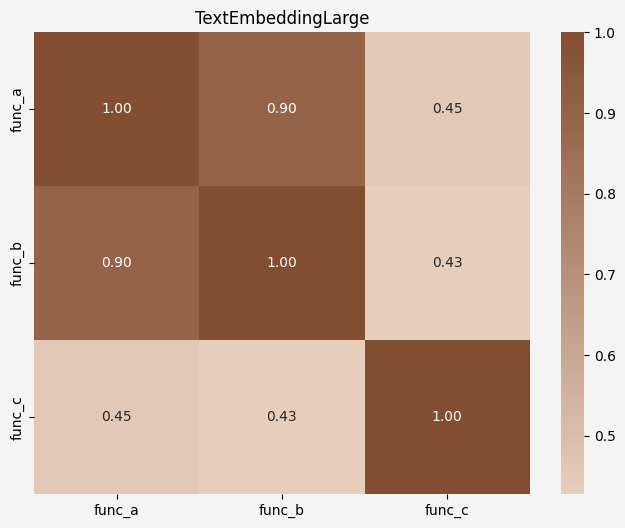

In [58]:
plot_heatmap(compute_similarity_matrix(generate_embeddings_openai("text-embedding-3-large", snipets)), ["anchor", "positive", "negative"], "OpenAI Embeddings")

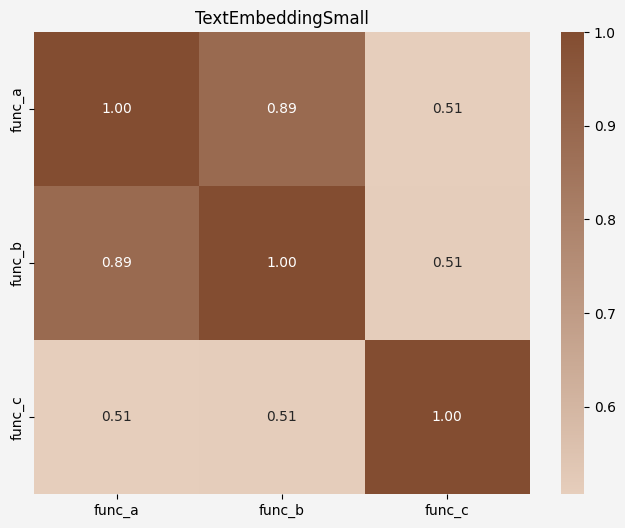

In [59]:
plot_heatmap(compute_similarity_matrix(generate_embeddings_openai("text-embedding-3-small", snipets)), ["anchor", "positive", "negative"], "OpenAI Embeddings")

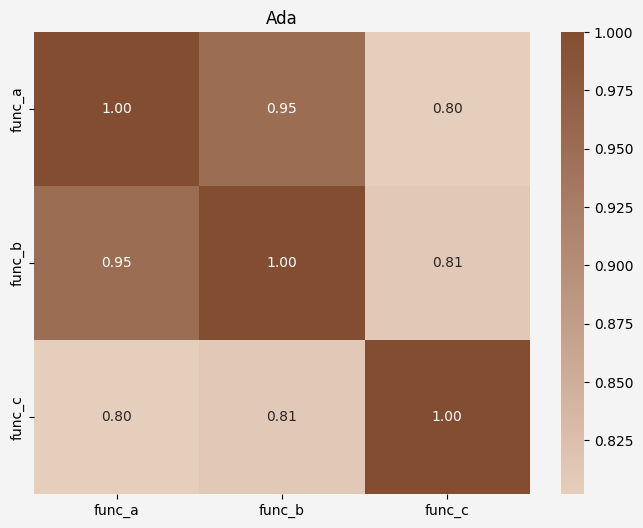

In [60]:
plot_heatmap(compute_similarity_matrix(generate_embeddings_openai("text-embedding-ada-002", snipets)), ["anchor", "positive", "negative"], "OpenAI Embeddings")